# This notebook contains 3 parts corresponding to the 3 questions of the instructions. 
1. Webscraping and creation of the dataframe containing the PostalCode, Borough and Neighborhood of the list of postal codes of Canada starting with 'M'
2. Fetching the coordinates of the neighborhoods
3. Exploring the neighborhoods with Foursquare, clustering the venues and displaying the clusters on the map 

## 1. Webscraping and creation of the dataframe containing the PostalCode, Borough and Neighborhood of the list of postal codes of Canada starting with 'M'

Ignore the warnings

In [178]:
import warnings
warnings.filterwarnings('ignore')

Importing the BeautifulSoup library to scrap the Wikipedia page:

In [179]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

In [180]:
page_canada_codes = urlopen("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(page_canada_codes, 'html.parser')
labels = ['PostalCode', 'Borough', 'Neighborhood']

Creation of the dataframe

In [181]:
df_neighnorhood = pd.DataFrame(columns=labels)
try:
    for tr in soup.find_all('tr')[2:]:
        tds = tr.find_all('td')
        df_neighnorhood = df_neighnorhood.append({'PostalCode': tds[0].text.replace('\n', ''), 'Borough': tds[1].text.replace('\n', ''), 'Neighborhood': tds[2].text.replace('\n', '')}, ignore_index=True)
except:
    pass
print(df_neighnorhood.head())

  PostalCode           Borough                      Neighborhood
0        M2A      Not assigned                      Not assigned
1        M3A        North York                         Parkwoods
2        M4A        North York                  Victoria Village
3        M5A  Downtown Toronto         Regent Park, Harbourfront
4        M6A        North York  Lawrence Manor, Lawrence Heights


Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [182]:
df_neighnorhood = df_neighnorhood[df_neighnorhood['Borough'] != 'Not assigned']
print(df_neighnorhood.head())

  PostalCode           Borough                                 Neighborhood
1        M3A        North York                                    Parkwoods
2        M4A        North York                             Victoria Village
3        M5A  Downtown Toronto                    Regent Park, Harbourfront
4        M6A        North York             Lawrence Manor, Lawrence Heights
5        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government


More than one neighborhood can exist in one postal code area. These two rows will be combined into one row with the neighborhoods separated with a comma.

In [183]:
print(df_neighnorhood.shape)
print(len(df_neighnorhood['PostalCode'].unique()))
# there's no duplicate, the neighborhoods were already concatenated
print(df_neighnorhood[df_neighnorhood['PostalCode'] == 'M5A'])

(103, 3)
103
  PostalCode           Borough               Neighborhood
3        M5A  Downtown Toronto  Regent Park, Harbourfront


If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [184]:
print(df_neighnorhood[df_neighnorhood['Neighborhood'] == 'Not assigned'])

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []


In [185]:
# in fact, all the 'Not assigned' neighborhoods were assigned to a 'Not assigned' borough, so removing the 'Not assigned' boroughs removed also the 'Not assigned' neighborhoods 
# if needed, here's the code
#df_neighnorhood.loc[df_neighnorhood['Neighborhood'] == 'Not assigned', 'Neighborhood'] =  df_neighnorhood.loc[df_neighnorhood['Neighborhood'] == 'Not assigned', 'Borough']
df_neighnorhood.head()

,PostalCode,Borough,Neighborhood
1,M3A,North York,Parkwoods
2,M4A,North York,Victoria Village
3,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,M6A,North York,"Lawrence Manor, Lawrence Heights"
5,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [186]:
print(df_neighnorhood.shape)

(103, 3)


## 2. Fetching the coordinates of the neighborhoods

Adding the columns 'Latitude' and 'Longitude'

In [187]:
df_neighnorhood['Latitude'] = 0
df_neighnorhood['Longitude'] = 0

In [188]:
from geopy.geocoders import Nominatim

In [189]:
geolocator = Nominatim(user_agent="coursera_capstone_project", timeout=1000)
def getCoord(_row, _geolocator):
    address = '{}, Toronto, Ontario'.format(_row['Neighborhood'])
    location = _geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude
def getLatitude(_row, _geolocator):
    return getCoord(_row, _geolocator)[0]
def getLongitude(_row, _geolocator):
    return getCoord(_row, _geolocator)[1]

In [190]:
df2 = df_neighnorhood.iloc[:2,:]
print(df2)

  PostalCode     Borough      Neighborhood  Latitude  Longitude
1        M3A  North York         Parkwoods         0          0
2        M4A  North York  Victoria Village         0          0


In [191]:
df2['Latitude'] = df2.apply(getLatitude, _geolocator=geolocator, axis=1)
df2['Longitude'] = df2.apply(getLongitude, _geolocator=geolocator, axis=1)

In [192]:
print(df2.head())

  PostalCode     Borough      Neighborhood   Latitude  Longitude
1        M3A  North York         Parkwoods  43.761124 -79.324059
2        M4A  North York  Victoria Village  43.732658 -79.311189


I can't use coordinates from the borough because the code depends on the neighborhood.<br>
But if I use the coordinates of the neighborhood, for a code (for ex. M5A), I can have two or more neighborhoods (ex. Regent Park, Harbourfront)...<br>
Which coordinates to choose ? the mean ? the farest ?<br>
I'm going to upload the .csv file from http://cocl.us/Geospatial_data given in the instructions

In [17]:
!wget -q -O 'Geospatial_Coordinates' http://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


In [193]:
df_coordinates = pd.read_csv('Geospatial_Coordinates')
print(df_coordinates.shape[0])
df_coordinates.head()

103


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


There are 103 rows, like in df_neighnorhood.<br>
Let's sort both dataframes and add the data from df_coordinates to df_neighnorhood !

In [194]:
df_neighnorhood.sort_values(by=['PostalCode'], inplace=True)
df_neighnorhood.reset_index(inplace=True, drop=True)
df_neighnorhood.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",0,0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",0,0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",0,0
3,M1G,Scarborough,Woburn,0,0
4,M1H,Scarborough,Cedarbrae,0,0


In [195]:
df_coordinates.sort_values(by=['Postal Code'], inplace=True)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [196]:
df_neighnorhood['Longitude'] = df_coordinates['Longitude']
df_neighnorhood['Latitude'] = df_coordinates['Latitude']

In [197]:
df_neighnorhood.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## 3. Exploring the neighborhoods with Foursquare, clustering the venues and displaying the clusters on the map

As wa can see it in the scatter below, the distance between two linked neighnorhoods is increasing when we start from the port and we go towards the surroundings. 

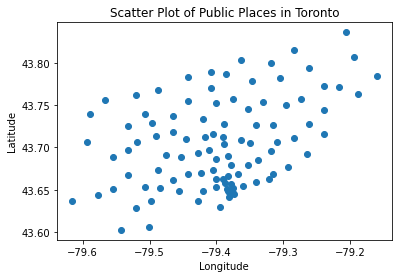

In [198]:
import matplotlib.pyplot as plt
lat_data = df_neighnorhood['Latitude']
lng_data = df_neighnorhood['Longitude']

plt.scatter(lng_data, lat_data)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Public Places in Toronto')
plt.show()

In [228]:
CLIENT_ID = '' # your Foursquare ID (I removed mine for public display)
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's see the first location

In [200]:
# for the firsst one
df_neighnorhood.loc[0, 'Neighborhood']

'Malvern, Rouge'

In [201]:
k=0
neighborhood_latitude = df_neighnorhood.loc[k, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_neighnorhood.loc[k, 'Longitude'] # neighborhood longitude value
neighborhood_name = df_neighnorhood.loc[k, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, neighborhood_latitude, neighborhood_longitude))

Latitude and longitude values of Malvern, Rouge are 43.806686299999996, -79.19435340000001.


In [202]:
def getUrl(_CLIENT_ID, _CLIENT_SECRET, _VERSION, _latitude, _longitude, _radius, _limit):
    '''
    _CLIENT_ID # client ID to use foursquare
    _CLIENT_SECRET # client secret ID to use foursquare
    _VERSION # the version of foursquare
    _latitude # the latitude of the center of the exploring
    _longitude # the longitude of the center of the exploring
    _radius # radius of the area around the coordinates to look for venues
    _limit # limit of number of venues returned by Foursquare API
    '''
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        _CLIENT_ID, 
        _CLIENT_SECRET, 
        _VERSION, 
        _latitude, 
        _longitude, 
        _radius, 
        _limit)
    return url

In [203]:
url0_500 = getUrl(CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, 500, 100)
print(url0_500)

https://api.foursquare.com/v2/venues/explore?&client_id=ID4QCCRTVSI1TCPEPRFJ2X1RUAY0XLTWBV3AV3X14RSSBFZS&client_secret=BADYIKT3KULKVNPKI55DN1QU2USC21LD1W0JILT2VZGBHCUB&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=500&limit=100


Let's emplore this first location

In [204]:
import requests # library to handle requests
def getJsonNearbyVenuesFromUrl(_url):
    return requests.get(_url).json()

In [205]:
results0_500 = getJsonNearbyVenuesFromUrl(url0_500)

In [206]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# function that extracts the category of the venue
def getCategoryType(_row):
    '''
    _row # row containing data for a venue
    '''
    try:
        categories_list = _row['categories']
    except:
        categories_list = _row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(_json_nearby_venues):
    '''
    _json_nearby_venues # the json content with all the nearby venues
    '''
    venues = _json_nearby_venues['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(getCategoryType, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    print("There are {} venues in this neighborhood !".format(nearby_venues.shape[0]))
    
    return nearby_venues   

Let's see how many venues we get for a 500 radius

In [207]:
getNearbyVenues(results0_500).head()

There are 1 venues in this neighborhood !


,name,categories,lat,lng
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056


As we can see, there's only 1 venue whith the radius 500. That's not enough. Let's try 1000

In [208]:
url0_1000 = getUrl(CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, 1000, 100)
print(url0_1000)
results0_1000 = getJsonNearbyVenuesFromUrl(url0_1000)
getNearbyVenues(results0_1000).head()

https://api.foursquare.com/v2/venues/explore?&client_id=ID4QCCRTVSI1TCPEPRFJ2X1RUAY0XLTWBV3AV3X14RSSBFZS&client_secret=BADYIKT3KULKVNPKI55DN1QU2USC21LD1W0JILT2VZGBHCUB&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=1000&limit=100
There are 19 venues in this neighborhood !


,name,categories,lat,lng
0,Images Salon & Spa,Spa,43.802283,-79.198565
1,Harvey's,Restaurant,43.800020,-79.198307
2,Wendy's,Fast Food Restaurant,43.802008,-79.198080
3,Wendy’s,Fast Food Restaurant,43.807448,-79.199056
4,RBC Royal Bank,Bank,43.798782,-79.197090


That's better !

Now, let's explore all the neighborhoods !

In [209]:
def getNearbyVenues(_CLIENT_ID, _CLIENT_SECRET, _VERSION, _neighborhoods_names, _neighborhoods_latitudes, _neighborhoods_longitudes, _radius, _limit):
    '''
    _CLIENT_ID # client ID to use foursquare
    _CLIENT_SECRET # client secret ID to use foursquare
    _VERSION # the version of foursquare
    _neighborhoods_names # list of the neighborhood names
    _neighborhoods_latitudes # list of the neighborhood latitudes
    _neighborhoods_longitudes # list of the neighborhood longitudes
    _radius # radius of the area around the coordinates to look for venues for each neighborhood
    _limit # limit of number of venues returned by Foursquare API for each neighborhood
    '''    
    venues_list=[]
    for name, lat, lng in zip(_neighborhoods_names, _neighborhoods_latitudes, _neighborhoods_longitudes):
        
        # create the API request URL
        url = getUrl(_CLIENT_ID, _CLIENT_SECRET, _VERSION, lat, lng, _radius, _limit)
            
        # make the GET request
        jsonNearbyVenuesFromUrl = getJsonNearbyVenuesFromUrl(url)
        results = jsonNearbyVenuesFromUrl["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [210]:
Toronto_venues = getNearbyVenues(CLIENT_ID, CLIENT_SECRET, VERSION, df_neighnorhood['Neighborhood'], df_neighnorhood['Latitude'], df_neighnorhood['Longitude'], 1000, 100)

In [211]:
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
1,"Malvern, Rouge",43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant
2,"Malvern, Rouge",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
3,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
4,"Malvern, Rouge",43.806686,-79.194353,RBC Royal Bank,43.798782,-79.197090,Bank


In [212]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 337 uniques categories.


In [213]:
def oneHotEncodingVenues(_Toronto_venues):
    '''
    _Toronto_venues # venues of Toronto
    '''
    # one hot encoding
    Toronto_onehot = pd.get_dummies(_Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    Toronto_onehot['Neighborhood'] = _Toronto_venues['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
    Toronto_onehot = Toronto_onehot[fixed_columns]

    return Toronto_onehot

Toronto_onehot = oneHotEncodingVenues(Toronto_venues)
Toronto_onehot.head()

,Zoo,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
Toronto_onehot.shape

(4985, 337)

Let's average the venues by neighborhood

In [215]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Zoo,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.000,0.017857,0.0,0.0,0.0,0.0,0.000,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.025,0.0,0.0,0.0,...,0.0,0.025,0.000000,0.0,0.0,0.0,0.0,0.025,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
95,Woburn,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
96,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0
97,York Mills West,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0


Let's display the 5 top venues frequencies for the 2 first neighborhoods 

In [216]:
def displayTopVenuesInNeighborhood(_num_top_venues, _Toronto_grouped, _n_display):
    '''
    _num_top_venues # number of top venues to display by neighborhood
    _Toronto_grouped # Toronto raw grouped data
    _n_display # number of neighborhood to display
    '''
    for i, hood in enumerate(_Toronto_grouped['Neighborhood']):
        if (i <_n_display):
            print("----"+hood+"----")
            temp = _Toronto_grouped[_Toronto_grouped['Neighborhood'] == hood].T.reset_index()
            temp.columns = ['venue','freq']
            temp = temp.iloc[1:]
            temp['freq'] = temp['freq'].astype(float)
            temp = temp.round({'freq': 2})
            print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(_num_top_venues))
            print('\n')

In [217]:
displayTopVenuesInNeighborhood(5, Toronto_grouped, 2)

----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.12
1  Caribbean Restaurant  0.05
2         Shopping Mall  0.05
3                Bakery  0.04
4           Coffee Shop  0.04


----Alderwood, Long Branch----
               venue  freq
0     Discount Store  0.12
1  Convenience Store  0.08
2        Pizza Place  0.08
3           Pharmacy  0.08
4               Park  0.08




In [218]:
import numpy as np
def returnMostCommonVenues(_row, _num_top_venues):
    '''
    _row # line of data
    _num_top_venues # number of top venues to display
    '''
    row_categories = _row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:_num_top_venues]

def getNeighborhoodsSortedVenues(_num_top_venues, _Toronto_grouped):
    '''
    _num_top_venues # number of top venues to display
    _Toronto_grouped # Toronto raw grouped data
    '''
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(_num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = _Toronto_grouped['Neighborhood']

    for ind in np.arange(_Toronto_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = returnMostCommonVenues(_Toronto_grouped.iloc[ind, :], _num_top_venues)
    
    return neighborhoods_venues_sorted

In [219]:
neighborhoods_venues_sorted = getNeighborhoodsSortedVenues(10, Toronto_grouped)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Caribbean Restaurant,Bakery,Indian Restaurant,Coffee Shop,Sandwich Place,Clothing Store,Bank,Bar
1,"Alderwood, Long Branch",Discount Store,Convenience Store,Pizza Place,Park,Pharmacy,Print Shop,Gym,Shopping Mall,Donut Shop,Garden Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Ice Cream Shop,Fried Chicken Joint,Gas Station,Sushi Restaurant,Supermarket,Frozen Yogurt Shop,Shopping Mall
3,Bayview Village,Bank,Gas Station,Grocery Store,Japanese Restaurant,Chinese Restaurant,Trail,Playground,Park,Restaurant,Café
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Pizza Place,Sandwich Place,Bank,Café,Sushi Restaurant,Baby Store,Thai Restaurant,Bagel Shop


### Clustering Neighborhoods

In [220]:
from sklearn.cluster import KMeans

def mergeTorontoDataByClusters(_kclusters, _Toronto_grouped, _neighborhoods_venues_sorted, _df_neighnorhood):
    '''
    _kclusters # nomber of clusters
    _Toronto_grouped # Toronto raw grouped data
    _neighborhoods_venues_sorted # sorted venues
    -df_neighnorhood # Toronto data
    '''

    Toronto_grouped_clustering = _Toronto_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=_kclusters, random_state=0).fit(Toronto_grouped_clustering)
    # add clustering labels
    new_neighborhoods_venues_sorted = _neighborhoods_venues_sorted.copy()

    new_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

    Toronto_merged = _df_neighnorhood.drop(['PostalCode'], axis=1)

    # merge Toronto_merged with _df_neighnorhood to add latitude/longitude for each neighborhood
    Toronto_merged = Toronto_merged.join(new_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
    
    return Toronto_merged

In [221]:
kclusters = 8
Toronto_merged_data_with_clusters = mergeTorontoDataByClusters(kclusters, Toronto_grouped, neighborhoods_venues_sorted, df_neighnorhood)
Toronto_merged_data_with_clusters.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4,Fast Food Restaurant,Trail,Coffee Shop,Bakery,Gym,Garden,Chinese Restaurant,Restaurant,Paper / Office Supplies Store,Supermarket
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,7,Breakfast Spot,Park,Burger Joint,Italian Restaurant,Playground,Yoga Studio,Field,Ethiopian Restaurant,Event Space,Falafel Restaurant
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Pizza Place,Bank,Coffee Shop,Fast Food Restaurant,Bus Line,Moving Target,Smoothie Shop,Sports Bar,Fried Chicken Joint,Supermarket
3,Scarborough,Woburn,43.770992,-79.216917,4,Park,Coffee Shop,Fast Food Restaurant,Dog Run,Chinese Restaurant,Indian Restaurant,Mobile Phone Shop,Flower Shop,Elementary School,Escape Room
4,Scarborough,Cedarbrae,43.773136,-79.239476,0,Bank,Pharmacy,Pizza Place,Bakery,Coffee Shop,Indian Restaurant,Gas Station,Thai Restaurant,Grocery Store,Chinese Restaurant


In [86]:
!pip install folium
import folium # map rendering library

     |████████████████████████████████| 93 kB 4.2 MB/s  eta 0:00:01


In [222]:
def displayMapClusters(_Toronto_merged_data_with_clusters, _kclusters):
    '''
    _Toronto_merged_data_with_clusters # all the data to be clustered
    _kclusters # number of clusters 
    '''
    # centering on one neighborhood
    latitude = df_coordinates.loc[0, 'Latitude']
    longitude =  df_coordinates.loc[0, 'Longitude']
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

    # set color scheme for the clusters
    # Matplotlib and associated plotting modules
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    x = np.arange(_kclusters)
    ys = [i + x + (i*x)**2 for i in range(_kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(_Toronto_merged_data_with_clusters['Latitude'], _Toronto_merged_data_with_clusters['Longitude'], _Toronto_merged_data_with_clusters['Neighborhood'], _Toronto_merged_data_with_clusters['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
    return map_clusters

In [223]:
map_clusters = displayMapClusters(Toronto_merged_data_with_clusters, kclusters)
map_clusters

We can see that there seems to be 4 "layers".<br>
- The first one (violet points) is centered above all on the port, the Old Toronto.
- The second one (red points) is quite mixed with the third one (turquoise points) but the turquoise points are farer from the ocean than the red points.
- The fourth one (pale green points) are quite remote from the center.

Examining clusters

Cluster number 0 (red points):

In [224]:
Toronto_merged_data_with_clusters.loc[Toronto_merged_data_with_clusters['Cluster Labels'] == 0, Toronto_merged_data_with_clusters.columns[[1] + list(range(5, Toronto_merged_data_with_clusters.shape[1]))]][:10]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Guildwood, Morningside, West Hill",Pizza Place,Bank,Coffee Shop,Fast Food Restaurant,Bus Line,Moving Target,Smoothie Shop,Sports Bar,Fried Chicken Joint,Supermarket
4,Cedarbrae,Bank,Pharmacy,Pizza Place,Bakery,Coffee Shop,Indian Restaurant,Gas Station,Thai Restaurant,Grocery Store,Chinese Restaurant
5,Scarborough Village,Ice Cream Shop,Train Station,Convenience Store,Playground,Pizza Place,Restaurant,Coffee Shop,Sandwich Place,Fast Food Restaurant,Sports Bar
7,"Golden Mile, Clairlea, Oakridge",Pharmacy,Bus Line,Coffee Shop,Bakery,Intersection,Ice Cream Shop,Soccer Field,General Entertainment,Beer Store,Metro Station
8,"Cliffside, Cliffcrest, Scarborough Village West",Pizza Place,Ice Cream Shop,Beach,Hardware Store,Chinese Restaurant,Sports Bar,Park,Restaurant,Elementary School,Escape Room
10,"Dorset Park, Wexford Heights, Scarborough Town...",Restaurant,Coffee Shop,Electronics Store,Bakery,Asian Restaurant,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Indian Restaurant,Bank
11,"Wexford, Maryvale",Middle Eastern Restaurant,Pizza Place,Hookah Bar,Grocery Store,Asian Restaurant,Korean Restaurant,Coffee Shop,Bakery,Seafood Restaurant,Badminton Court
29,"Northwood Park, York University",Coffee Shop,Furniture / Home Store,Restaurant,Pizza Place,Bar,Bank,Sandwich Place,Caribbean Restaurant,Automotive Shop,Massage Studio
35,"Parkview Hill, Woodbine Gardens",Construction & Landscaping,Brewery,Pizza Place,Coffee Shop,Gym / Fitness Center,Road,Soccer Stadium,Breakfast Spot,Fast Food Restaurant,Gastropub
37,The Beaches,Pub,Coffee Shop,Pizza Place,Breakfast Spot,Beach,Japanese Restaurant,Park,Burger Joint,Caribbean Restaurant,Bar


Cluster number 1 (violet points):

In [225]:
Toronto_merged_data_with_clusters.loc[Toronto_merged_data_with_clusters['Cluster Labels'] == 1, Toronto_merged_data_with_clusters.columns[[1] + list(range(5, Toronto_merged_data_with_clusters.shape[1]))]][0:10]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Fairview, Henry Farm, Oriole",Coffee Shop,Clothing Store,Bank,Sandwich Place,Restaurant,Bakery,Japanese Restaurant,Juice Bar,Sporting Goods Shop,Fried Chicken Joint
21,"Willowdale, Newtonbrook",Korean Restaurant,Café,Diner,Pizza Place,Coffee Shop,Middle Eastern Restaurant,Park,Bank,Supermarket,Sandwich Place
22,"Willowdale, Willowdale East",Coffee Shop,Korean Restaurant,Ramen Restaurant,Bubble Tea Shop,Japanese Restaurant,Pizza Place,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Restaurant
26,Don Mills,Coffee Shop,Restaurant,Japanese Restaurant,Gym,Burger Joint,Café,Supermarket,Pizza Place,Beer Store,Bank
27,Don Mills,Coffee Shop,Restaurant,Japanese Restaurant,Gym,Burger Joint,Café,Supermarket,Pizza Place,Beer Store,Bank
34,Victoria Village,Coffee Shop,Portuguese Restaurant,Intersection,Golf Course,Park,Grocery Store,Gym / Fitness Center,Café,Men's Store,Boxing Gym
36,Woodbine Heights,Park,Coffee Shop,Pizza Place,Café,Skating Rink,Sandwich Place,Beer Store,Plaza,Farmers Market,Snack Place
40,"East Toronto, Broadview North (Old East York)",Café,Coffee Shop,Greek Restaurant,Ethiopian Restaurant,Beer Bar,Pizza Place,Fast Food Restaurant,Pharmacy,American Restaurant,Convenience Store
41,"The Danforth West, Riverdale",Greek Restaurant,Café,Coffee Shop,Pub,Spa,Bank,Italian Restaurant,Yoga Studio,Bakery,Bookstore
43,Studio District,Coffee Shop,Bar,American Restaurant,Brewery,Bakery,Vietnamese Restaurant,Diner,Café,Italian Restaurant,French Restaurant


Cluster number 4 (turquoise points):

In [226]:
Toronto_merged_data_with_clusters.loc[Toronto_merged_data_with_clusters['Cluster Labels'] == 4, Toronto_merged_data_with_clusters.columns[[1] + list(range(5, Toronto_merged_data_with_clusters.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",Fast Food Restaurant,Trail,Coffee Shop,Bakery,Gym,Garden,Chinese Restaurant,Restaurant,Paper / Office Supplies Store,Supermarket
3,Woburn,Park,Coffee Shop,Fast Food Restaurant,Dog Run,Chinese Restaurant,Indian Restaurant,Mobile Phone Shop,Flower Shop,Elementary School,Escape Room
9,"Birch Cliff, Cliffside West",Park,Ice Cream Shop,College Stadium,Café,Skating Rink,General Entertainment,Motorcycle Shop,Gym,Gym Pool,Auto Workshop
19,Bayview Village,Bank,Gas Station,Grocery Store,Japanese Restaurant,Chinese Restaurant,Trail,Playground,Park,Restaurant,Café
23,York Mills West,Park,Restaurant,Coffee Shop,Dog Run,Gym,Playground,Intersection,Business Service,Grocery Store,Bowling Alley
28,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Ice Cream Shop,Fried Chicken Joint,Gas Station,Sushi Restaurant,Supermarket,Frozen Yogurt Shop,Shopping Mall
44,Lawrence Park,Park,Bookstore,Gym / Fitness Center,Trail,Coffee Shop,College Gym,College Quad,Café,Fireworks Store,Farmers Market
50,Rosedale,Coffee Shop,Park,Grocery Store,Metro Station,Athletics & Sports,Breakfast Spot,Filipino Restaurant,Candy Store,Bistro,Sandwich Place
64,"Forest Hill North & West, Forest Hill Road Park",Park,Coffee Shop,Café,Bank,Gym / Fitness Center,Burger Joint,Liquor Store,Sushi Restaurant,Japanese Restaurant,Italian Restaurant
74,Caledonia-Fairbanks,Park,Pharmacy,Pizza Place,Food Truck,Bus Line,Portuguese Restaurant,Bus Stop,Mexican Restaurant,Fast Food Restaurant,Falafel Restaurant


Cluster number 5 (pale green points):

In [227]:
Toronto_merged_data_with_clusters.loc[Toronto_merged_data_with_clusters['Cluster Labels'] == 5, Toronto_merged_data_with_clusters.columns[[1] + list(range(5, Toronto_merged_data_with_clusters.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Kennedy Park, Ionview, East Birchmount Park",Chinese Restaurant,Coffee Shop,Burger Joint,Pizza Place,Grocery Store,Fast Food Restaurant,Discount Store,Light Rail Station,Sandwich Place,Train Station
12,Agincourt,Chinese Restaurant,Shopping Mall,Caribbean Restaurant,Bakery,Indian Restaurant,Coffee Shop,Sandwich Place,Clothing Store,Bank,Bar
13,"Clarks Corners, Tam O'Shanter, Sullivan",Coffee Shop,Pharmacy,Sandwich Place,Fast Food Restaurant,Bank,Intersection,Pizza Place,Convenience Store,Vietnamese Restaurant,Hobby Shop
14,"Milliken, Agincourt North, Steeles East, L'Amo...",Chinese Restaurant,Pizza Place,Park,Intersection,Noodle House,Malay Restaurant,Shop & Service,Shopping Mall,Caribbean Restaurant,Bakery
15,"Steeles West, L'Amoreaux West",Chinese Restaurant,Bank,Fast Food Restaurant,Pizza Place,Intersection,Bakery,Coffee Shop,Grocery Store,Gym Pool,Breakfast Spot
17,Hillcrest Village,Pharmacy,Park,Coffee Shop,Ice Cream Shop,Grocery Store,Pizza Place,Convenience Store,Recreation Center,Residential Building (Apartment / Condo),Restaurant
24,"Willowdale, Willowdale West",Pharmacy,Eastern European Restaurant,Coffee Shop,Bakery,Convenience Store,Bus Line,Park,Grocery Store,Pizza Place,Butcher
25,Parkwoods,Park,Convenience Store,Bus Stop,Pharmacy,Shopping Mall,Fish & Chips Shop,Chinese Restaurant,Supermarket,Laundry Service,Shop & Service
30,Downsview,Vietnamese Restaurant,Coffee Shop,Hotel,Grocery Store,Gas Station,Park,Pharmacy,Pizza Place,Athletics & Sports,Sandwich Place
31,Downsview,Vietnamese Restaurant,Coffee Shop,Hotel,Grocery Store,Gas Station,Park,Pharmacy,Pizza Place,Athletics & Sports,Sandwich Place


Of these 8 clusters, 4 only contain one venue. <br>
We can inspect the clusters 0 (red points), 1 (violet points), 4 (turquoise points) and 5 (pale green points).<br>
- The cluster 4 seems to contain a lot of parks. There are located around the center but quite far away. 
- The cluster 5 semms to contain a lot of restaurants and Coffee Shops. But it's more diversified than the cluster 1
- The cluster 1 seems to contain above all restaurants and Coffee Shops, cafés etc. It must be the main touristic area.
- The cluster 0 is more diversified. 